# <center> AI4LR - Final Assignment [100 Points]

In [ ]:
# IMPORTANT
Your_name = "Karthick k"
Your_emailid = "Karthi.13light@gmail.com"

---

## Dataset
- Add [this dataset](https://www.kaggle.com/datasets/romainpessia/artificial-lunar-rocky-landscape-dataset) to your Kaggle notebook.

## Instructions for this project
- Don't forget to turn on GPU for training your model(s).
- Without changing anything in the notebook if you run it then you will get the val_iou_score of around 0.20.
- Your goal of this project is to increase this val_iou_score as much as you can.
- Evaluation of this project will be based on your best acquired val_iou_score seen in the notebook.
- Your val_iou_score will be the percentage you will receive for this project. 
- If your best val_iou_score is 0.41 then you will score 41/100 points in this project.
- Try to avoid any errors before submitting your notebook.

## Tips to increase the performance of your model
- Increase the number of epochs.
- Increase the number of layers in your model.
- Using SOTA high performance networks with transfer learning.
- Using callbacks and carefully observing your model performance.
- You can use the methods taught to you in this training program or any other methods of your own choice to increase the performance!

## Guidelines on making changes to this notebook
**1)** Add a descriptive comment to your code for whatever changes you are making in this notebook.
- For example, if you are adding an extra Conv2D layer, write about all the aspects of the Conv2D layer you are adding.
- The commnt should be placed at the point where the layer will be added.

**2)** Show model properties before and after the changes were made.
- For example, if you changed the layers - added, deleted, e.t.c.

**3)** If you use new data preprocessing techniques that are not already part of this notebook, you must explain their inner workings using markdown cells.
- Without this explanation, your techniques will not be considered for evaluation.
- Use texts and images to explain this process.

**4)** Make use of tables and plots that contributed to the improvement of your model.
- Assume if increasing the epochs and decreasing the learning rate contributed in the improvement of your model.
- You will first show these improvements using plots of val_iou_scores vs epochs as well as val_iou_scores vs learning rate.0
- Then make use of tables to show iou scores for different learning rates.
- For example, table 1 for lr_1 to show iou values for epochs 30 t0 50, table 2 to show iou values from epochs 30 to 50, and so on.
- It is therefore advised to work on one improvement, optimize it, plot it, document it, then proceed to the next improvement - till you get a satisfactory IOU score.

**5)** Final improvement summary table.
- Prepare a table with columns (changes, improvments description, increase in iou from, increase in iou to)
- List out all the changes you made to improve your final model performance.

## Coding for this project

In [ ]:
!pip install segmentation_models

In [ ]:
# import the necessary Library

import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 
from sklearn.model_selection import train_test_split

* Provide environment variable SM_FRAMEWORK=keras / SM_FRAMEWORK=tf.keras before import segmentation_models
* Change framework sm.set_framework('keras') / sm.set_framework('tf.keras')

In [ ]:
# Setting framework environment
os.environ["SM_FRAMEWORK"] = "tf.keras"
sm.set_framework('tf.keras')
keras.backend.set_image_data_format('channels_last')

## Data Preprocessing Pipeline

In [ ]:
H = 480 # height of image # Here the height of the image is changed to 480 from 256. This may reduce the data loss , as the original image size is 720 * 480
W = 480 # width of image #here the width of the is changed to 480 from 256. The reason is same

'''This function is used to return the list of path for images and masks in
sorted order from the given directory respectively.'''
# function to return list of image paths and mask paths 
def process_data(IMG_DIR, MASK_DIR):
    images = [os.path.join(IMG_DIR, x) for x in sorted(os.listdir(IMG_DIR))]
    masks = [os.path.join(MASK_DIR, x) for x in sorted(os.listdir(MASK_DIR))]
    return images, masks

'''This function is used to return splitted list of images and corresponding 
mask paths in train and test by providing test size.'''
# function to load data and train test split
def load_data(IMG_DIR, MASK_DIR):
    X, y = process_data(IMG_DIR, MASK_DIR)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

'''This function is used to read images. It takes image path as input. 
After reading image it is resized by width and height provide above(256 x 256). 
Next normalization is done by dividing each values with 255. And the result is returned.'''
# function to read image
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

'''This function is used to read masks.'''
# function to read mask
def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x.astype(np.int32)
    return x

'''This function is used to generate tensorflow data pipeline. 
The tensorflow data pipeline is mapped to function ‘preprocess’ .'''
# function for tensorflow dataset pipeline
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

'''This function takes image and mask path. 
It reads the image and mask as provided by paths. 
Mask is one hot encoded for multi class segmentation (here 4 class).'''
# function to read image and mask amd create one hot encoding for mask
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        image = read_image(x)
        mask = read_mask(y)

        return image, mask

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    mask = tf.one_hot(mask, 4, dtype=tf.int32)
    image.set_shape([H, W, 3])
    mask.set_shape([H, W, 4])

    return image, mask

## Load the dataset

In [ ]:
'''RENDER_IMAGE_DIR_PATH: ‘Path of image directory’
GROUND_MASK_DIR_PATH: ‘Path of mask directory’

Here load_data function is called. This will load the dataset paths and 
split it into X_train, X_test, y_train, y_test '''

RENDER_IMAGE_DIR_PATH = '../input/artificial-lunar-rocky-landscape-dataset/images/render'
GROUND_MASK_DIR_PATH = '../input/artificial-lunar-rocky-landscape-dataset/images/clean'

X_train, X_test, y_train, y_test = load_data(RENDER_IMAGE_DIR_PATH, GROUND_MASK_DIR_PATH)
print(f"Dataset:\n Train: {len(X_train)} \n Test: {len(X_test)}")

Dataset:
 Train: 7812 
 Test: 1954


## Generate tensorflow data pipeline

In [ ]:
batch_size = 16 #batch size is doubled. this will increase the efficiency of the model.

'''Here the tf_dataset function is called will generate the tensorflow data pipeline.'''
# calling tf_dataset
train_dataset = tf_dataset(X_train, y_train, batch=batch_size)
valid_dataset = tf_dataset(X_test, y_test, batch=batch_size)

## Creating U-net Architecture

Here we are going to use vgg-16 backbone to build U-net architecture using transfer learning.

In [ ]:
## Step-1: Creating base model 
IMG_SHAPE = (480, 480, 3)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')

## Step-2: Freezing the base model
# Freezing should be done before training. this would prevent update of weight in given layer
base_model.trainable = False
base_model.summary()

## Step-3: Adding the head
# inputs
inputs = tf.keras.Input(shape=(480, 480, 3))
# base with pretrained model
x = base_model(inputs, training=False)
# layers of head
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(2)(x)

# model
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 480, 480, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 480, 480, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 480, 480, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 240, 240, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 240, 240, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 240, 240, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 120, 120, 128)     0     

In [ ]:
BACKBONE = 'vgg16'
input_shape = (480, 480, 3)
n_class = 4
activation = 'softmax'

# we are creating U-Net using segementation model through Vgg16 as backbone
# This model will add mirror image to contraction path 
model = sm.Unet(backbone_name = BACKBONE, 
                input_shape = input_shape, 
                classes = n_class, 
                activation = activation,
                encoder_weights = 'imagenet')
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 480, 480, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 480, 480, 64) 1792        input_13[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 480, 480, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 240, 240, 64) 0           block1_conv2[0][0]               
___________________________________________________________________________________________

## Load model and compile

In [ ]:
# importing libraries
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from segmentation_models.metrics import iou_score
import datetime, os

""" Defining Hyperparameters """
img_shape = (480, 480, 3) #This is the input shape.
num_classes = 4
lr = 1e-5 #as much you decrease , we will get better generaslisation
batch_size = 16
epochs = 8 #I increased epochs to get better score

""" Model building and compiling """
# metrics for result validation
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
# compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(lr, epsilon=1e-8, decay=1e-6),metrics = metrics)
train_steps = len(X_train)//batch_size
valid_steps = len(X_test)//batch_size

""" Callbacks """
current_datetime = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=f'models/LunarModel.h5', monitor='val_iou_score', verbose=1, mode='max', save_best_only=True), 
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_iou_score", mode='max', patience=4, factor=0.1, verbose=1, min_lr=1e-6),
             tf.keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=5, verbose=1, mode='max')]

## Train model

In [ ]:
'''model.fit is used to train the model'''
model_history = model.fit(train_dataset,
        steps_per_epoch=train_steps,
        validation_data=valid_dataset,
        validation_steps=valid_steps,
        epochs=epochs,
    )

Epoch 1/8
488/488 [==============================] - 742s 2s/step - loss: 0.7075 - iou_score: 0.0801 - f1-score: 0.1123 - val_loss: 0.5009 - val_iou_score: 0.1601 - val_f1-score: 0.1949
Epoch 2/8
488/488 [==============================] - 735s 2s/step - loss: 0.3502 - iou_score: 0.2274 - f1-score: 0.2446 - val_loss: 0.2636 - val_iou_score: 0.3354 - val_f1-score: 0.3427
Epoch 3/8
488/488 [==============================] - 735s 2s/step - loss: 0.2132 - iou_score: 0.4700 - f1-score: 0.4766 - val_loss: 0.1721 - val_iou_score: 0.6458 - val_f1-score: 0.6516
Epoch 4/8
488/488 [==============================] - 737s 2s/step - loss: 0.1513 - iou_score: 0.5335 - f1-score: 0.5396 - val_loss: 0.1269 - val_iou_score: 0.5464 - val_f1-score: 0.5537
Epoch 5/8
488/488 [==============================] - 734s 2s/step - loss: 0.1244 - iou_score: 0.4835 - f1-score: 0.4907 - val_loss: 0.1103 - val_iou_score: 0.6075 - val_f1-score: 0.6140
Epoch 6/8
488/488 [==============================] - 735s 2s/step - lo

In [ ]:
print(model_history.history)

{'loss': [0.7075363397598267, 0.3501974046230316, 0.21320781111717224, 0.151299387216568, 0.12440797686576843, 0.09910914301872253, 0.07809744030237198, 0.06142817437648773], 'iou_score': [0.08005586266517639, 0.22736066579818726, 0.469962477684021, 0.5335178971290588, 0.48350006341934204, 0.6456146836280823, 0.738678514957428, 0.7401715517044067], 'f1-score': [0.11232234537601471, 0.2446339726448059, 0.47656330466270447, 0.5396267175674438, 0.49072906374931335, 0.651045024394989, 0.7439441084861755, 0.7449694871902466], 'val_loss': [0.5008986592292786, 0.263568252325058, 0.17205455899238586, 0.12693336606025696, 0.11033459007740021, 0.08377684652805328, 0.06674763560295105, 0.05612218752503395], 'val_iou_score': [0.1600561887025833, 0.3354343771934509, 0.6458176374435425, 0.546374499797821, 0.6074533462524414, 0.7375553846359253, 0.7398613691329956, 0.7401691675186157], 'val_f1-score': [0.19488942623138428, 0.34266799688339233, 0.6516282558441162, 0.5536677837371826, 0.613972783088684

## [IMPORTANT] Paste you final model training history here in the markdown.(just double click this line, and you'll be able to edit it. 

NOTE: If we find that your actual model score and what you paste here is differing, your assignment will get rejected.  

here ----


# **Model histories given below :**

In [ ]:
History_1 = {'loss': [0.5984277725219727, 0.3573857247829437, 0.24004290997982025, 0.16470076143741608, 0.13713842630386353], 
'iou_score': [0.1166997030377388, 0.15338383615016937, 0.17699980735778809, 0.1930825561285019, 0.19635359942913055], 
'val_loss': [0.4423363506793976, 0.30066871643066406, 0.20033034682273865, 0.14634183049201965, 0.11715567857027054], 
'val_iou_score': [0.13592185080051422, 0.16570517420768738, 0.18757089972496033, 0.19637364149093628, 0.195452019572258]}

History_2 = {'loss': [0.48761430382728577, 0.27456820011138916, 0.18208512663841248, 0.12785212695598602, 0.09350620210170746], 
'iou_score': [0.12687207758426666, 0.16102993488311768, 0.17878015339374542, 0.19000090658664703, 0.1975499987602234], 
'val_loss': [0.33451005816459656, 0.2412446290254593, 0.1614338457584381, 0.12275522202253342, 0.07784944027662277], 
'val_iou_score': [0.15292774140834808, 0.16778601706027985, 0.18559810519218445, 0.1921360194683075, 0.20022352039813995]}

History_3 = {'loss': [0.64536635518074036, 0.3937649995088577, 0.2412974593043327, 0.1150687876343727, 0.09274173140525818], 
'iou_score': [0.36826464533805847, 0.7057791948318481, 0.6297565698623657, 0.5204053521156311, 0.5541524887084961], 
'f1-score': [0.3827938735485077, 0.7152298092842102, 0.649531364440918, 0.5456835627555847, 0.5792655944824219], 
'val_loss': [0.0813726857304573, 0.032043855637311935, 0.036784738302230835, 0.019282961264252663, 0.023523643612861633], 
'val_iou_score': [0.2010038185119629, 0.2408210229873657, 0.2971740007400513, 0.31030866026878357, 0.3241242909431458]}

History_4 = {'loss': [0.7075363397598267, 0.3501974046230316, 0.21320781111717224, 0.151299387216568, 0.12440797686576843, 0.09910914301872253, 0.07809744030237198, 0.06142817437648773], 
'iou_score': [0.08005586266517639, 0.22736066579818726, 0.469962477684021, 0.5335178971290588, 0.48350006341934204, 0.6456146836280823, 0.738678514957428, 0.7401715517044067], 
'f1-score': [0.11232234537601471, 0.2446339726448059, 0.47656330466270447, 0.5396267175674438, 0.49072906374931335, 0.651045024394989, 0.7439441084861755, 0.7449694871902466], 
'val_loss': [0.5008986592292786, 0.263568252325058, 0.17205455899238586, 0.12693336606025696, 0.11033459007740021, 0.08377684652805328, 0.06674763560295105, 0.05612218752503395], 
'val_iou_score': [0.1600561887025833, 0.3354343771934509, 0.6458176374435425, 0.546374499797821, 0.6074533462524414, 0.7375553846359253, 0.7398613691329956, 0.7401691675186157]}

In [ ]:
# Code to generate graph
import matplotlib.pyplot as plt
def Plotting(history1, history2):
        plt.plot(history1['val_iou_score'])
        plt.plot(history2['val_iou_score'])
        plt.title('Model Performance')
        plt.xlabel('epochs')
        plt.ylabel('val_iou_score')
        plt.legend(['Previous Val_iou_score', 'New Val_iou_score'])
        plt.show()

In [ ]:
# code to create tables
from tabulate import tabulate
def comprasion_table(history1,history2):
    mydata = [[history1, history2]]
    head = ["Previous score", "New score"]
    print(tabulate(mydata, headers=head, tablefmt="grid"))

# History 1 to History 2

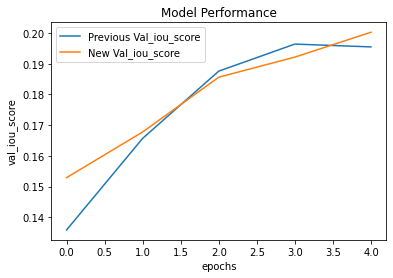


+------------------+-------------+
|   Previous score |   New score |
+==================+=============+
|         0.195452 |    0.200224 |
+------------------+-------------+

The Trial 1 score is default run without any changes. in trial 2 I given two important changes, where i changed the size of the image from 256 x 256 to 480 x 480. Then i doubled the batch size from 8 to 16. this shown an margin increment , which might not be seen an improvement but numerically it is increased.


In [ ]:
Plotting(History_1,History_2)
print()
comprasion_table(History_1["val_iou_score"][-1],History_2["val_iou_score"][-1])
print("\nThe Trial 1 score is default run without any changes. in trial 2 I given two important changes, where i changed the size of the image from 256 x 256 to 480 x 480. Then i doubled the batch size from 8 to 16. this shown an margin increment , which might not be seen an improvement but numerically it is increased.")

# History 2 to History 3

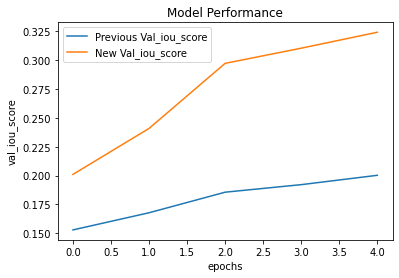


+------------------+-------------+
|   Previous score |   New score |
+==================+=============+
|         0.200224 |    0.324124 |
+------------------+-------------+

From history to when comapre to history 3, we can see an good improvement in the score. the reason behind this , I implemented the vgg16-backbone transfer learning technique and introduced metric for result validation. I maintained epoch as 5 for experimental phase.


In [ ]:
Plotting(History_2,History_3)
print()
comprasion_table(History_2["val_iou_score"][-1],History_3["val_iou_score"][-1])
print("\nFrom history to when comapre to history 3, we can see an good improvement in the score. the reason behind this , I implemented the vgg16-backbone transfer learning technique and introduced metric for result validation. I maintained epoch as 5 for experimental phase.")

# History 3 to History 4

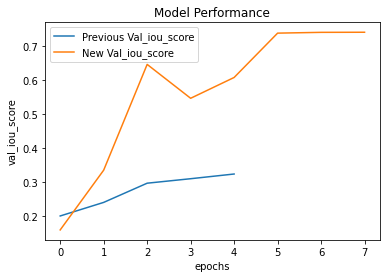


+------------------+-------------+
|   Previous score |   New score |
+==================+=============+
|         0.324124 |    0.740169 |
+------------------+-------------+

An drastic improvement seen in score. this might be the final score , as i implemented all known techniques to improve score. First i decreased the learning rate to 1 x 10-5. then epsilon and decay are used to improve the score. This decay used to reduce the complexity of model and prevent overfitting


In [ ]:
Plotting(History_3,History_4)
print()
comprasion_table(History_3["val_iou_score"][-1],History_4["val_iou_score"][-1])
print("\nAn drastic improvement seen in score. this might be the final score , as i implemented all known techniques to improve score. First i decreased the learning rate to 1 x 10-5. then epsilon and decay are used to improve the score. This decay used to reduce the complexity of model and prevent overfitting")

# Final improvement summary table
|History (Trial) | changes made | increase in iou from | increase in iou to |
|:---| :----: | :---:| :---:|
| 1 | default notebook runned without any change | --- | 0.1955 |
| 2 | Changed the size of the image and increased the batch size | 0.1955| 0.2002|
| 3 | Implemented vgg-16 Transfer learning technique, maintained same epoch 5 | 0.2002 | 0.3241 |
| 4 | Decreased learning rate, Increased epoch to 8, epsilon and decay added | 0.3241 | 0.7401 |

---
# <center> THE END